In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arch
#import os
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_arch
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

# Data preparation

## Loading dataset

In [2]:
#os.chdir("nauka\pies")
#os.getcwd()

<Axes: xlabel='date'>

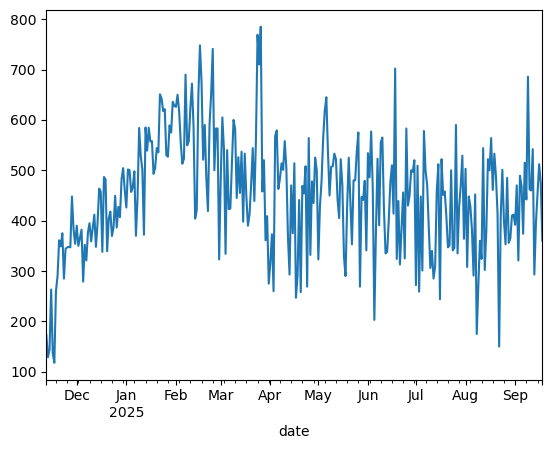

In [3]:
raw_df = pd.read_excel("dog_food_consumption.xlsx", sheet_name="Arkusz2", index_col=0, parse_dates=True, usecols=list(range(4,11)))
raw_df.index.name="date"
raw_df.rename(columns={'porcja [g]': 'weight [g]'}, inplace=True)
raw_df = raw_df['weight [g]']
raw_df = raw_df.groupby(by='date').sum()
raw_df.plot()

## Small EDA and slicing dataset

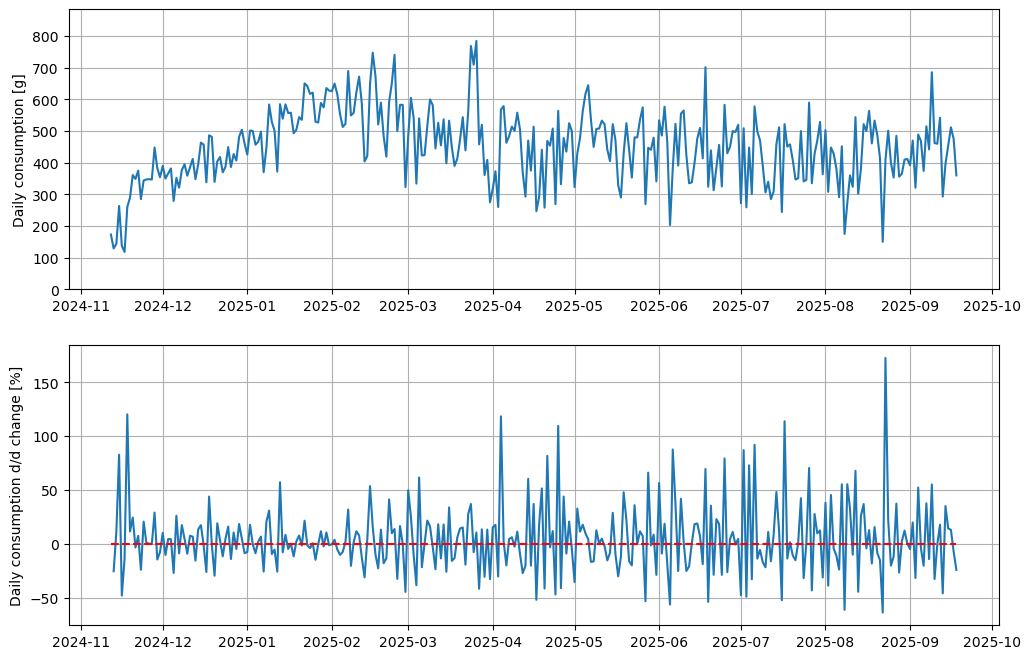

In [4]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(raw_df)
plt.ylabel('Daily consumption [g]')
plt.ylim(bottom=0, top=max(raw_df)+100)
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(raw_df.pct_change()*100)
plt.ylabel('Daily consumption d/d change [%]')
plt.hlines(y=0, color='r', ls='--', xmin=min(raw_df.index), xmax=max(raw_df.index))
plt.grid()

plt.show()

The daily consumption data display a quite stable trend could be since around 03.2025-04.2025 - most of daily values circle within the same range.

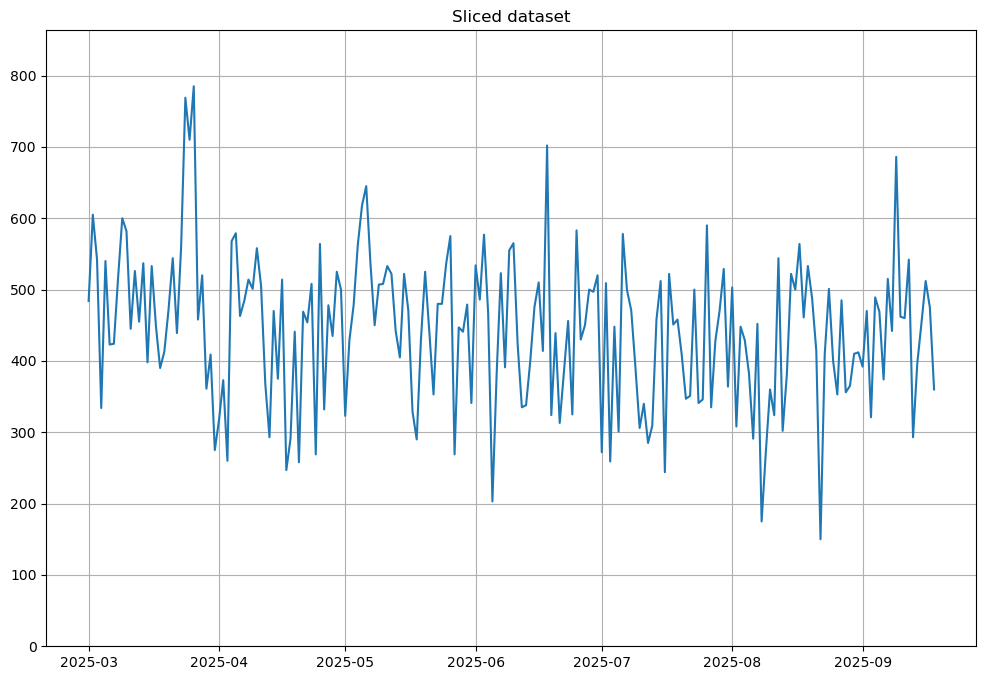

In [5]:
df = raw_df.loc['2025-03-01':].copy()
plt.figure(figsize=(12, 8))
plt.plot(df)
plt.ylim(bottom=0, top=max(df)*1.1)
plt.grid()
plt.title('Sliced dataset')
plt.show()

# ARIMA

## Testing stationarity

To make a reliable ARIMA model it is needed to check stationarity which is done by the Augmented Dickey-Fuller test.

In [6]:
adf_res = adfuller(df)
print(f'ADF statistic: {adf_res[0]}')
print(f'p-value: {adf_res[1]}')
if adf_res[1] < 0.05:
    print('The series is stationary.')
    print('The series is ready to be inputed into a model.')
else:
    print('The series is NOT stationary.')
    print('The series needs to modified e.g. set different range of differentate the series') 

ADF statistic: -7.589452706015908
p-value: 2.554355511280316e-11
The series is stationary.
The series is ready to be inputed into a model.


## Estimating parameters

### ACF and PACF plots

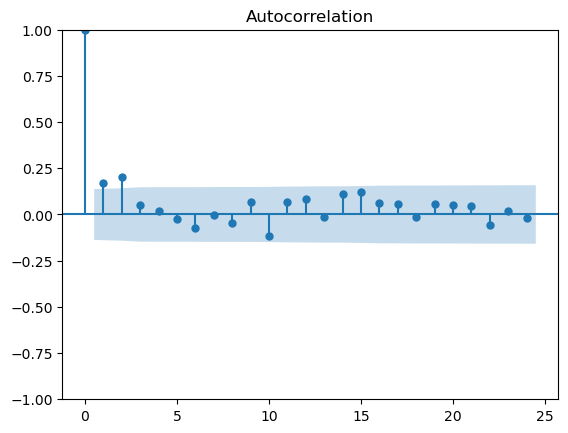

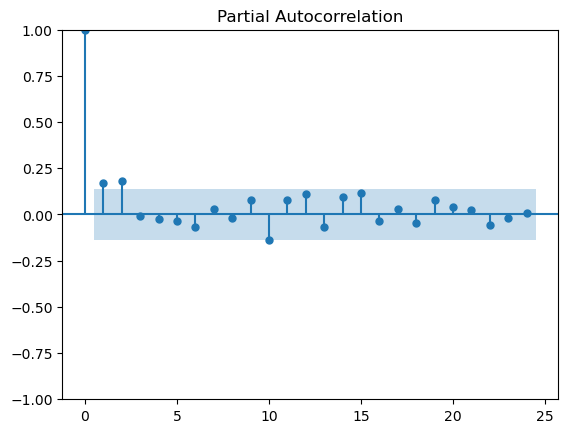

In [7]:
plot_acf(df)
plot_pacf(df);

ACF (q) and PACF (p) show the values for lags 1 and 2 are barely significant.

### Testing multiple parameters combinations

In [8]:
model = auto_arima(df, start_p=0, start_q=0, d=0, max_p=8, max_q=8, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2456.396, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2452.576, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2454.185, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3048.132, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=2447.716, Time=0.07 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=2449.714, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=2449.716, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2452.977, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=2451.715, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=2498.519, Time=0.04 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 0.700 seconds


In [9]:
pq = []
aic = []
bic = []
for p in range(0, 8):
    for q in range(0, 8):
        model = ARIMA(df, order=(p, 0, q))
        res = model.fit()
        pq.append( (p, q) )
        aic.append(res.aic)
        bic.append(res.bic)
    print(f'Models for the p={p} have been done.')
results = pd.DataFrame(data={'p q': pq, 'aic': aic, 'bic': bic})
results.set_index('p q', inplace=True)
print(f'The lowest AIC value is for the {results['aic'].idxmin()}', 
      f'The lowest BIC value is for the {results['bic'].idxmin()}', 
      sep='\n')

Models for the p=0 have been done.
Models for the p=1 have been done.
Models for the p=2 have been done.
Models for the p=3 have been done.
Models for the p=4 have been done.
Models for the p=5 have been done.
Models for the p=6 have been done.
Models for the p=7 have been done.
The lowest AIC value is for the (2, 5)
The lowest BIC value is for the (2, 0)


<Axes: xlabel='p q'>

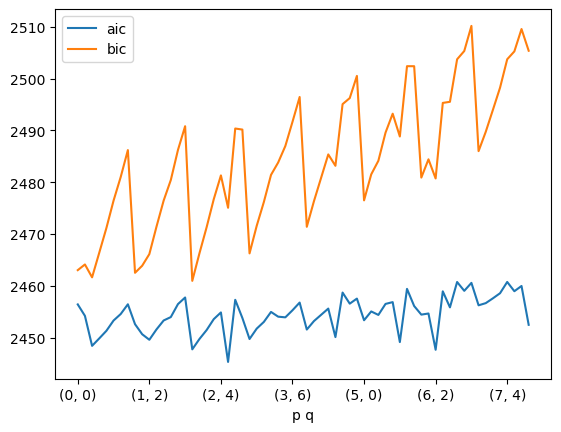

In [10]:
results.plot()

So the parameters will be (2, 0, 5)

## Creating the final ARIMA model

In [11]:
model = ARIMA(df, order=(2, 0, 5))
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             weight [g]   No. Observations:                  202
Model:                 ARIMA(2, 0, 5)   Log Likelihood               -1213.644
Date:                Thu, 18 Sep 2025   AIC                           2445.289
Time:                        23:13:05   BIC                           2475.063
Sample:                    03-01-2025   HQIC                          2457.335
                         - 09-18-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        443.1109     11.976     37.001      0.000     419.639     466.583
ar.L1         -1.6719      0.051    -32.986      0.000      -1.771      -1.573
ar.L2         -0.9122      0.045    -20.252      0.000      -1.000      -0.824
ma.L1          1.8871      0.094     20.149      0.000       1.703       2.071
ma.L2          1.4505      0.168      8.619      0.000       1.121       1.780
ma.L3          0.5704      0.179      3.183      0.001       0.219       0.922
ma.L4          0.4011      0.174      2.309      0.021       0.061       0.742
ma.L5          0.1712      0.097      1.757      0.079      -0.020       0.362
sigma2      1.044e+04   1190.622      8.767      0.000    8104.800    1.28e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.52
Prob(Q):                              0.89   Prob(JB):                         0.77
Heteroskedasticity (H):               0.94   Skew:                            -0.12
Prob(H) (two-sided):                  0.79   Kurtosis:                         2.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

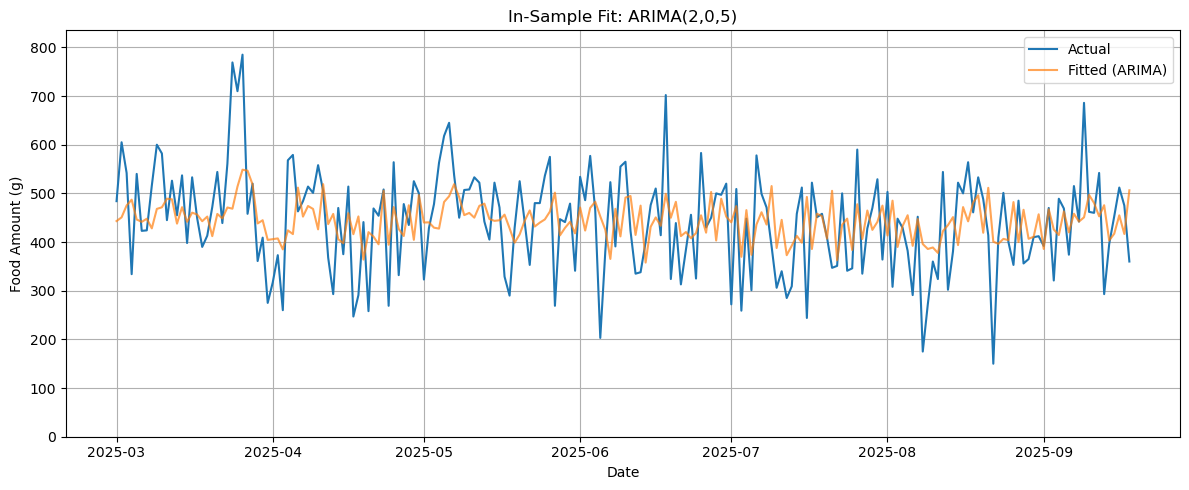

In [12]:
plt.figure(figsize=(12,5))
plt.plot(df, label='Actual')
plt.plot(res.fittedvalues, label='Fitted (ARIMA)', alpha=0.7)
plt.title("In-Sample Fit: ARIMA(2,0,5)")
plt.xlabel("Date")
plt.ylabel("Food Amount (g)")
plt.ylim(bottom=0, top=max(df)+50)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

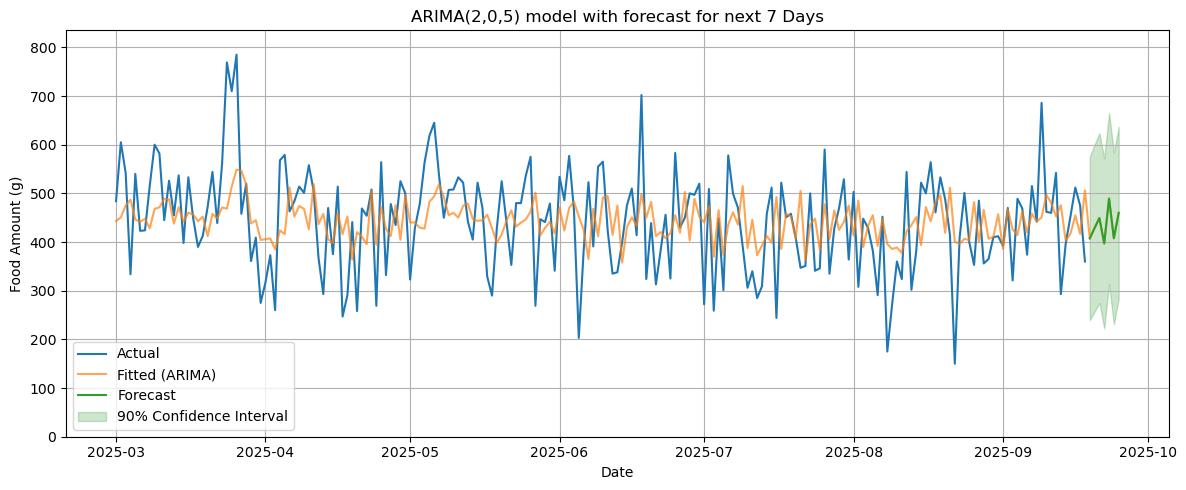

In [13]:
forecast_horizon=7
forecast_res = res.get_forecast(steps=forecast_horizon)
forecast_mean = forecast_res.predicted_mean
conf_int = forecast_res.conf_int(alpha=0.1)
plt.figure(figsize=(12, 5))

plt.plot(df, label="Actual")

plt.plot(pd.concat([res.fittedvalues, forecast_mean]), label='Fitted (ARIMA)', alpha=0.7)

plt.plot(forecast_mean.index, forecast_mean, label="Forecast")

plt.fill_between(forecast_mean.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1],
                 color='green', alpha=0.2, label="90% Confidence Interval")

plt.title(f"ARIMA(2,0,5) model with forecast for next {forecast_horizon} Days")
plt.xlabel("Date")
plt.ylabel("Food Amount (g)")
plt.ylim(bottom=0, top=max(df)+50)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
forecast_mean

2025-09-19    407.401776
2025-09-20    428.885354
2025-09-21    449.255031
2025-09-22    397.151849
2025-09-23    489.313326
2025-09-24    407.790019
2025-09-25    460.017111
Freq: D, Name: predicted_mean, dtype: float64

## Modeling forecast error using neural networks

## Modeling forecast error using GARCH

In [15]:
acorr_ljungbox(res.resid, lags=10)

,lb_stat,lb_pvalue
1,0.011403,0.914960
2,0.015429,0.992315
3,0.039937,0.997903
4,0.208727,0.994919
5,0.252237,0.998446
6,0.646311,0.995577
7,1.107124,0.992911
8,1.524427,0.992295
9,1.551963,0.996743
10,3.784259,0.956555


In [16]:
het_arch(res.resid)

(np.float64(8.925564883142016),
 np.float64(0.5391820544573613),
 0.882442839611931,
 0.5507344720037286)

# Neural networks